# Animal Image Classification

# Imports

In [35]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Constants

In [10]:
PATH = "/Users/maukanmir/Downloads/animal_data/"
BATCH_SIZE= 32
INPUT_SHAPE= (224,224,3)

# Functions

In [41]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def process_images(img_path, target_size=INPUT_SHAPE):
  try:
    with Image.open(img_path) as image:
      image = image.resize(target_size[:2])
      image = image.convert("RGB")
      image_array = np.array(image)/255.0
      image_array = image_array.astype(np.float32)
      return image_array
  except IOError as e:
    print(f"There was an error processing this image: {e}")
    return None
  
def grab_images(path):
  
  images, labels = [], []
  
  for root, dir, files in os.walk(path):
    for file in files:
      if file.lower().endswith((".png", ".jpeg", ".jpg")):
        img_path = os.path.join(root, file)
        img = process_images(img_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  
  return images, labels

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 6))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Class Balance")
  plt.xticks(rotation=45)
  plt.show()
  
  plt.figure(figsize=(10,6))
  sns.countplot(x=target)
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()
  

# Load in Dataset

In [29]:
X, y = grab_images(PATH)

# EDA Analysis

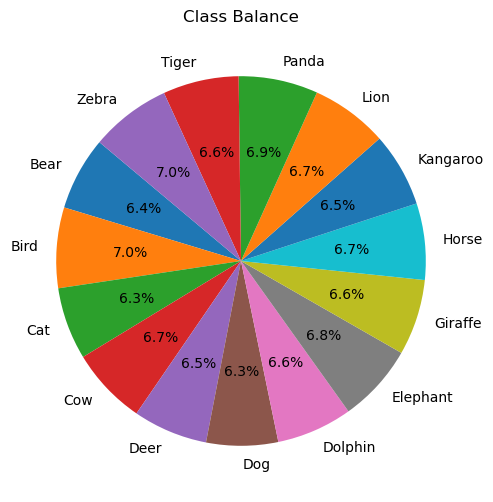

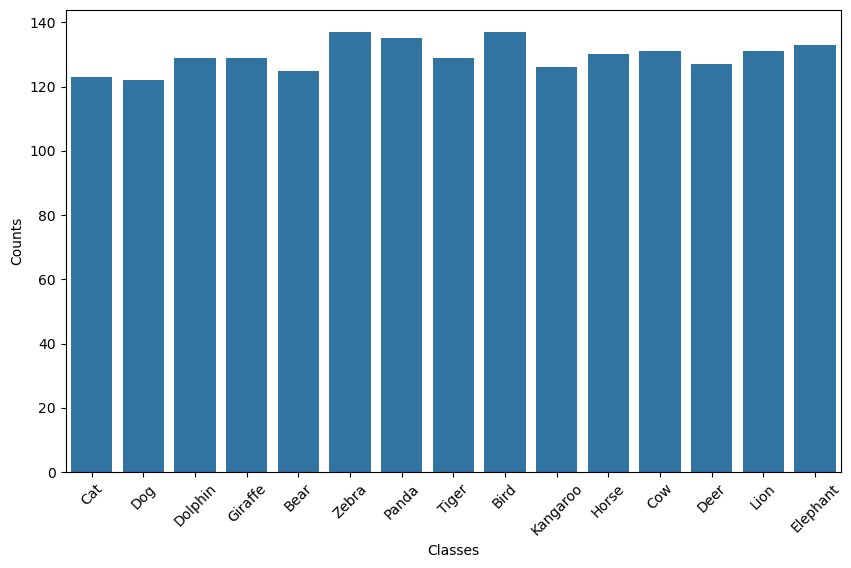

In [42]:
check_class_imbalance(y)

# Class is moderately Balanced

# Lets get a look at some of our images

# Transform Target Data

In [39]:
label_encoder = LabelEncoder()

y_int = label_encoder.fit_transform(y)

# Split Data into Train, Test and Validation splits

In [40]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [ ]:
# EDA Analysis